In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, EfficientNetB0, ResNet101, DenseNet121
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf


In [2]:
# def dice_coef(y_true, y_pred):
#  return (2. * tf.math.reduce_sum(y_true * y_pred) + 1.) / (tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) + 1.0)

In [3]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [4]:
import cv2

In [5]:
import os

In [6]:
def prerpocess_images(path_of_image: str):
  images_list = os.listdir(path_of_image)
  img_left_area = (0, 0, 256, 256)
  img_right_area = (256, 0, 512, 256)
  x = []
  y = []
  for img in images_list:
    my_img = image.load_img(path_of_image + img)
    x.append(my_img.crop(img_left_area))
    y.append(my_img.crop(img_right_area))
  return x, y

In [7]:
train_path = '/content/drive/MyDrive/cityscapes_data/train/'
valid_path = '/content/drive/MyDrive/cityscapes_data/val/'

In [8]:
x_train, y_train = prerpocess_images(train_path)

In [9]:
x_valid, y_valid = prerpocess_images(valid_path)

In [10]:
x_train[233], y_train[233]

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7FE16C702530>,
 <PIL.Image.Image image mode=RGB size=256x256 at 0x7FE16C702500>)

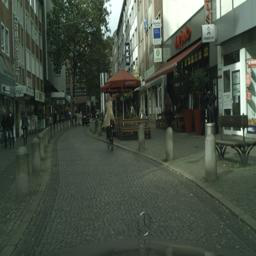

In [11]:
x_train[233]

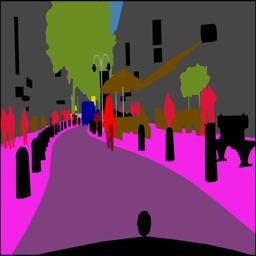

In [12]:
y_train[233]

In [13]:
len(x_train) == len(y_train)

True

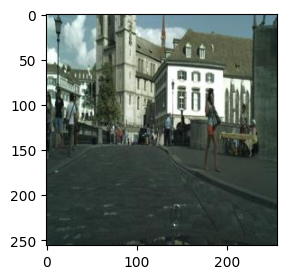

In [14]:
plt.figure(figsize=(4, 3))
plt.imshow(x_train[0])
plt.show()

In [15]:
# нижележащее описание категорий и цветов взято из GitHub
#  https://github.molgen.mpg.de/mohomran/cityscapes/blob/master/scripts/helpers/labels.py#L55

In [16]:
from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


In [17]:
id2color = {label.id : np.asarray(label.color) for label in labels }

In [18]:
id2color

{0: array([0, 0, 0]),
 1: array([0, 0, 0]),
 2: array([0, 0, 0]),
 3: array([0, 0, 0]),
 4: array([0, 0, 0]),
 5: array([111,  74,   0]),
 6: array([81,  0, 81]),
 7: array([128,  64, 128]),
 8: array([244,  35, 232]),
 9: array([250, 170, 160]),
 10: array([230, 150, 140]),
 11: array([70, 70, 70]),
 12: array([102, 102, 156]),
 13: array([190, 153, 153]),
 14: array([180, 165, 180]),
 15: array([150, 100, 100]),
 16: array([150, 120,  90]),
 17: array([153, 153, 153]),
 18: array([153, 153, 153]),
 19: array([250, 170,  30]),
 20: array([220, 220,   0]),
 21: array([107, 142,  35]),
 22: array([152, 251, 152]),
 23: array([ 70, 130, 180]),
 24: array([220,  20,  60]),
 25: array([255,   0,   0]),
 26: array([  0,   0, 142]),
 27: array([ 0,  0, 70]),
 28: array([  0,  60, 100]),
 29: array([ 0,  0, 90]),
 30: array([  0,   0, 110]),
 31: array([  0,  80, 100]),
 32: array([  0,   0, 230]),
 33: array([119,  11,  32]),
 -1: array([  0,   0, 142])}

In [19]:
def find_closest_labels_vectorized(mask, mapping): # 'mapping' is a RGB color tuple to categorical number dictionary

    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000)
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)

    for id, color in mapping.items(): # iterate over every color mapping
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category)

    return closest_category

In [20]:
picture = image.img_to_array(y_train[0])

In [21]:
picture = find_closest_labels_vectorized(picture, id2color)

In [22]:
picture.shape

(256, 256)

In [23]:
picture

array([[0, 0, 0, ..., 0, 27, 0],
       [27, 11, 11, ..., 11, 12, 28],
       [27, 12, 12, ..., 12, 12, 28],
       ...,
       [6, 7, 7, ..., 7, 7, 6],
       [6, 11, 11, ..., 11, 11, 27],
       [0, 0, 0, ..., 0, 27, 0]], dtype=object)

In [24]:
def cats2colors(picture):
  tmp = np.zeros([picture.shape[0], picture.shape[1], 3])
  for row in range(picture.shape[0]):
    for col in range(picture.shape[1]):
      tmp[row, col, :] = id2color[picture[row, col]]
      tmp = tmp.astype('uint8')

  return tmp

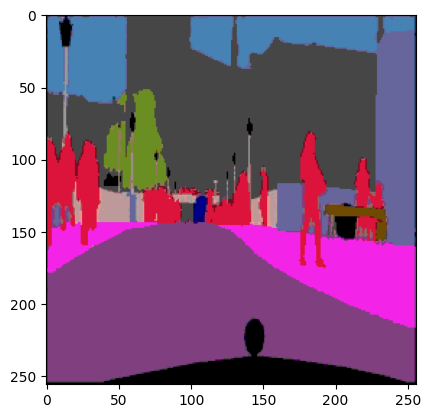

In [25]:
plt.imshow(cats2colors(picture))

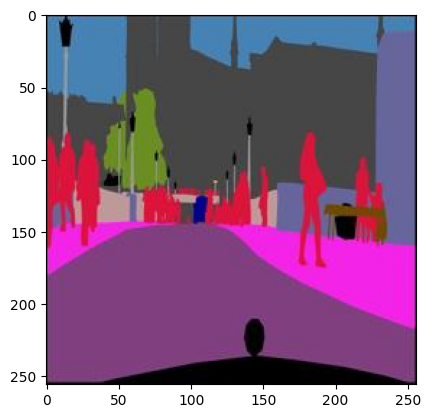

In [26]:
plt.imshow(y_train[0])

In [27]:
x_train = x_train[:100]
y_train = y_train[:100]
x_valid = x_valid[:100]
y_valid = y_valid[:100]

In [28]:
train_img = [image.img_to_array(i) for i in x_train]
train_mask = [image.img_to_array(i) for i in y_train]
train_enc_mask = [find_closest_labels_vectorized(picture, id2color) for picture in train_mask]
val_img = [image.img_to_array(i) for i in x_valid]
val_mask = [image.img_to_array(i) for i in y_valid]
val_enc_mask = [find_closest_labels_vectorized(picture, id2color) for picture in val_mask]

In [29]:
# def all_idx(idx, axis):
#    grid = np.ogrid[tuple(map(slice, idx.shape))]
#    grid.insert(axis, idx)
#    return tuple(grid)

In [30]:
def onehot_initialization_v2(a):
    ncols = a.max()+1
    out = np.zeros( (a.size,ncols), dtype=np.uint8)
    out[np.arange(a.size),a.ravel()] = 1
    out.shape = a.shape + (ncols,)
    return out

In [31]:
# def onehot_initialization(a):
 #   ncols = a.max()+1
 #   out = np.zeros(a.shape + (ncols,), dtype=float)
 #   out[all_idx(a, axis=2)] = 1
 #   return out

In [32]:
train_enc_mask = np.array(train_enc_mask, dtype=int)
val_enc_mask = np.array(val_enc_mask, dtype=int)

In [33]:
train_enc_mask = onehot_initialization_v2(train_enc_mask)

In [34]:
val_enc_mask = onehot_initialization_v2(val_enc_mask)

In [35]:
# train_enc_mask = [onehot_initialization_v2(a) for a in train_enc_mask]
# val_enc_mask = [onehot_initialization_v2(a) for a in val_enc_mask]

In [36]:
train_enc_mask.shape

(100, 256, 256, 34)

In [37]:
train_img = np.array(train_img, dtype=float)
train_enc_mask = train_enc_mask.astype(float)
val_img = np.array(val_img, dtype=float)
val_enc_mask = val_enc_mask.astype(float)

In [38]:
train_img.shape

(100, 256, 256, 3)

In [39]:
from tensorflow.keras.utils import plot_model

In [40]:
def Unet(num_classes = 34, input_shape=(256, 256, 3)):
  img_input = Input(input_shape)
# Первый блок

  x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
  x = BatchNormalization()(x)
  block_1_out = Activation('relu')(x)

  x = MaxPooling2D()(block_1_out)

# Второй блок
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
  x = BatchNormalization()(x)
  block_2_out = Activation('relu')(x)

  x = MaxPooling2D()(block_2_out)

# Третий блок
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
  x = BatchNormalization()(x)
  block_3_out = Activation('relu')(x)

  x = MaxPooling2D()(block_3_out)

# Четвертый блок

  x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
  x = BatchNormalization()(x)
  block_4_out = Activation('relu')(x)


  x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(block_4_out)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_3_out])
  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_2_out])
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = concatenate([x, block_1_out])
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

  model = Model(img_input, x)
  model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
  return model

In [41]:
modelC = Unet(34, (256, 256, 3))

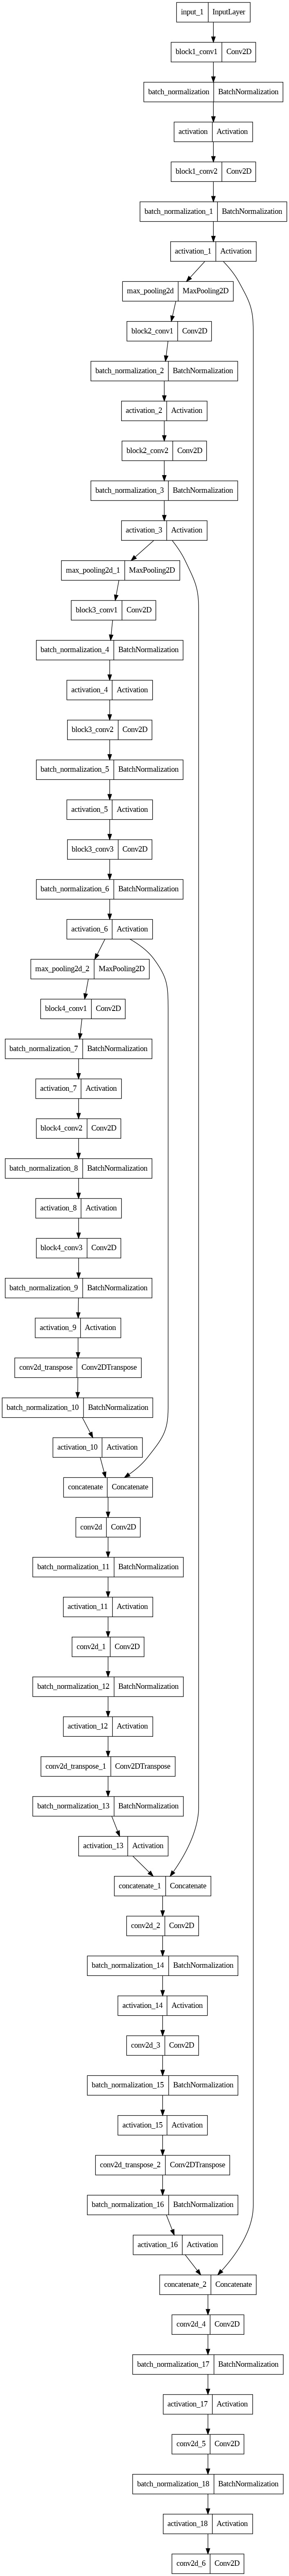

In [42]:
plot_model(modelC, to_file='modelC.png')

In [43]:
history = modelC.fit(train_img, train_enc_mask, epochs=50, batch_size=1, validation_data=(val_img, val_enc_mask))

Epoch 1/50
100/100 [==============================] - 39s 124ms/step - loss: 1.7141 - dice_coef: 0.3695 - val_loss: 39.4836 - val_dice_coef: 0.1589
Epoch 2/50
100/100 [==============================] - 9s 94ms/step - loss: 1.3558 - dice_coef: 0.4649 - val_loss: 2.1239 - val_dice_coef: 0.2596
Epoch 3/50
100/100 [==============================] - 9s 92ms/step - loss: 1.2601 - dice_coef: 0.4994 - val_loss: 1.9597 - val_dice_coef: 0.4751
Epoch 4/50
100/100 [==============================] - 9s 94ms/step - loss: 1.1718 - dice_coef: 0.5299 - val_loss: 2.7658 - val_dice_coef: 0.2821
Epoch 5/50
100/100 [==============================] - 9s 92ms/step - loss: 1.1736 - dice_coef: 0.5209 - val_loss: 1.7510 - val_dice_coef: 0.4244
Epoch 6/50
100/100 [==============================] - 9s 93ms/step - loss: 1.1452 - dice_coef: 0.5368 - val_loss: 1.4626 - val_dice_coef: 0.4983
Epoch 7/50
100/100 [==============================] - 10s 95ms/step - loss: 1.1201 - dice_coef: 0.5440 - val_loss: 2.4375 - val

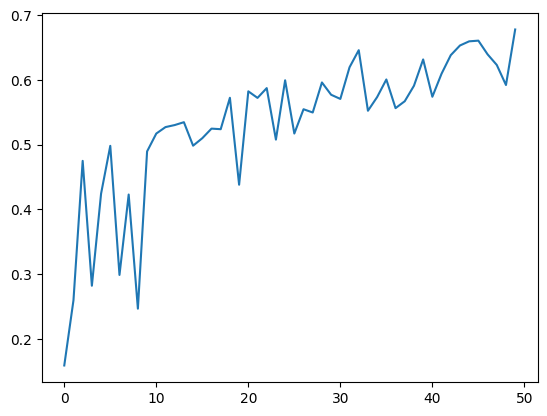

In [44]:
plt.plot(history.history['val_dice_coef'])
plt.show()

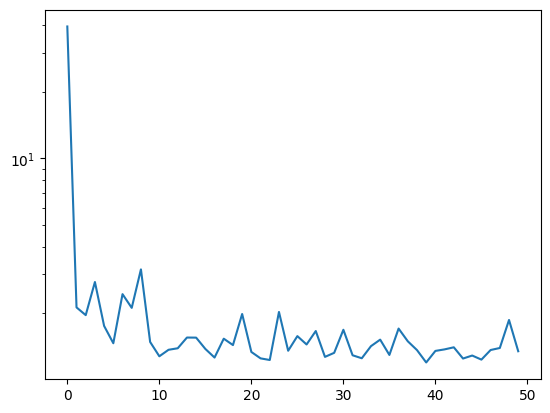

In [45]:
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.show()

In [ ]:
# modelC.evaluate(val_img, val_enc_mask)

In [66]:
def make_preds_and_recieve_pic(img):
  img = img.reshape(1, 256, 256, 3)
  pred = modelC.predict(img)
  pred = pred.reshape(256, 256, 34)
  pred = np.argmax(pred, axis=2)
  pred = cats2colors(pred)

  return pred

In [67]:
pic = make_preds_and_recieve_pic(val_img[1])

1/1 [==============================] - 0s 37ms/step


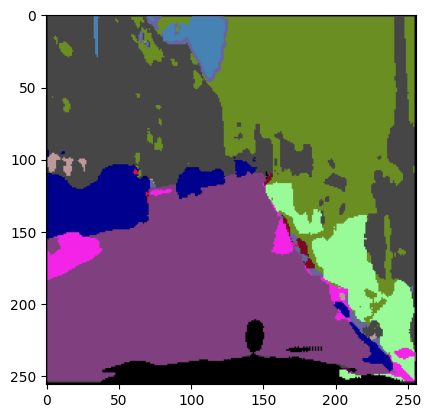

In [69]:
plt.imshow(pic)
plt.show()

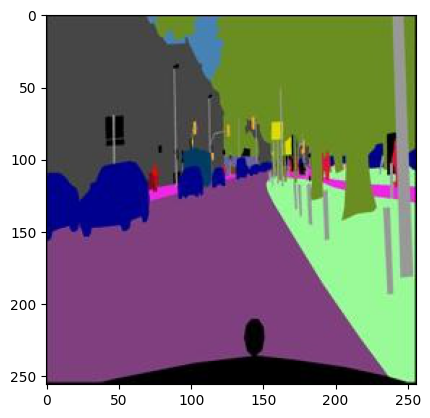

In [71]:
plt.imshow(y_valid[1])
plt.show()